## Model Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from itertools import permutations
from itertools import combinations
from pyEDM import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import time
import os
from copy import deepcopy
import math
import random
from sklearn.metrics import root_mean_squared_error
from scipy.stats import ttest_ind
import pickle
import ast
import json



from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import warnings
warnings.filterwarnings("ignore", 
    message="A worker stopped while some jobs were given to the executor.",
    module="joblib.externals.loky.process_executor")

In [2]:
data_path = "Data/data_w_gaps_and_wind.csv"
model_path = "Results/100_sample_baseline_models.csv"


In [3]:
def str_to_list(s):
    s = s.replace('nan', 'null')  # Replace 'nan' with 'null' for JSON compatibility
    lst = json.loads(s)  # Convert string to list
    lst = [np.nan if x is None else x for x in lst]  # Replace None with np.nan
    return lst

def process_parameters(path):

    parameters = pd.read_csv(path) 
    parameters['pred'] = parameters['pred'].apply(str_to_list)
    parameters['columns'] = parameters['columns'].apply(ast.literal_eval)
    parameters.sort_values(by='rho',ascending=False)
    return parameters

def clean_data(data_path):
    paper_data = pd.read_csv(data_path)
    paper_data = paper_data.set_index('time')
    paper_data['Time'] = paper_data.index.astype(int)
    paper_data['Avg_Chloro'] #= paper_data['Avg_Chloro'].apply(np.log1p) #LOG AMPUTATION
    #IMPUTE HAB DATA
    #Build basic linear regression model as sanity check
    # Custom impute missing values with the average of the value in front and behind of it 
    class ForwardBackwardImputer(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
            X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')

            return (X_filled_forward + X_filled_backward) / 2


    Imputer = ForwardBackwardImputer()
    paper_data = paper_data.apply(pd.to_numeric, errors='coerce')
    Imputer.fit(paper_data)
    paper_data = Imputer.transform(paper_data)#COMMENT OUT IF DONT WANT MEAN MPUTE
    return paper_data

In [11]:

data = clean_data(data_path)
parameters = process_parameters(model_path)
target = 'Avg_Chloro'
parameters

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_16145/1510975273.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_16145/1510975273.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')


,Unnamed: 0,target,columns,E,theta,rho,rmse,pred
0,0,Avg_Chloro,"[Avg_Chloro(t-0), Avg_Chloro(t-2), BOT_SAL_PSU...",3,1,0.348395,8.576572,"[nan, 3.526515729584963, 2.9197215239716465, 5..."
1,1,Avg_Chloro,"[BOT_DENS_kgm3(t-0), Nitrate(t-0), Nitrite(t-1...",3,1,0.344812,8.496430,"[nan, 5.0997976386271, 3.5845770802801056, 4.4..."
2,2,Avg_Chloro,"[Nitrate(t-1), WSPD(t-0), WSPD(t-2), Avg_Chlor...",3,1,0.347225,8.480067,"[nan, 4.00846399735425, 4.127242576888831, 3.4..."
3,3,Avg_Chloro,"[BOT_DENS_kgm3(t-0), Nitrate(t-2), Nitrite(t-2...",3,1,0.305332,8.865705,"[nan, 3.8946819587873174, 3.3001794692333215, ..."
4,4,Avg_Chloro,"[AVG_TEMP_C(t-2), Nitrite(t-1), WSPD(t-0), Avg...",3,1,0.344319,8.480932,"[nan, 4.699400123487491, 3.4996390260087304, 5..."
...,...,...,...,...,...,...,...,...
16928,16928,Avg_Chloro,"[AVG_SAL_PSU(t-0), AVG_TEMP_C(t-0), Avg_Chloro...",7,45,0.193113,16.552215,"[nan, 1.0675630262834437, 22.677413483734068, ..."
16929,16929,Avg_Chloro,"[AVG_SAL_PSU(t-2), AVG_TEMP_C(t-0), Avg_Chloro...",7,45,0.135273,17.641273,"[nan, -4.18884983883518, -0.3629619177005097, ..."
16930,16930,Avg_Chloro,"[AVG_TEMP_C(t-1), Avg_Chloro(t-0), BOT_DENS_kg...",7,45,0.219001,16.642203,"[nan, 4.058398594142705, 0.5272074118460376, 4..."
16931,16931,Avg_Chloro,"[AVG_TEMP_C(t-1), Avg_Chloro(t-1), BOT_DENS_kg...",7,45,0.481260,20.718532,"[nan, 0.05081254859258344, 18.786651601125985,..."


In the 95 percentile there are 846 models


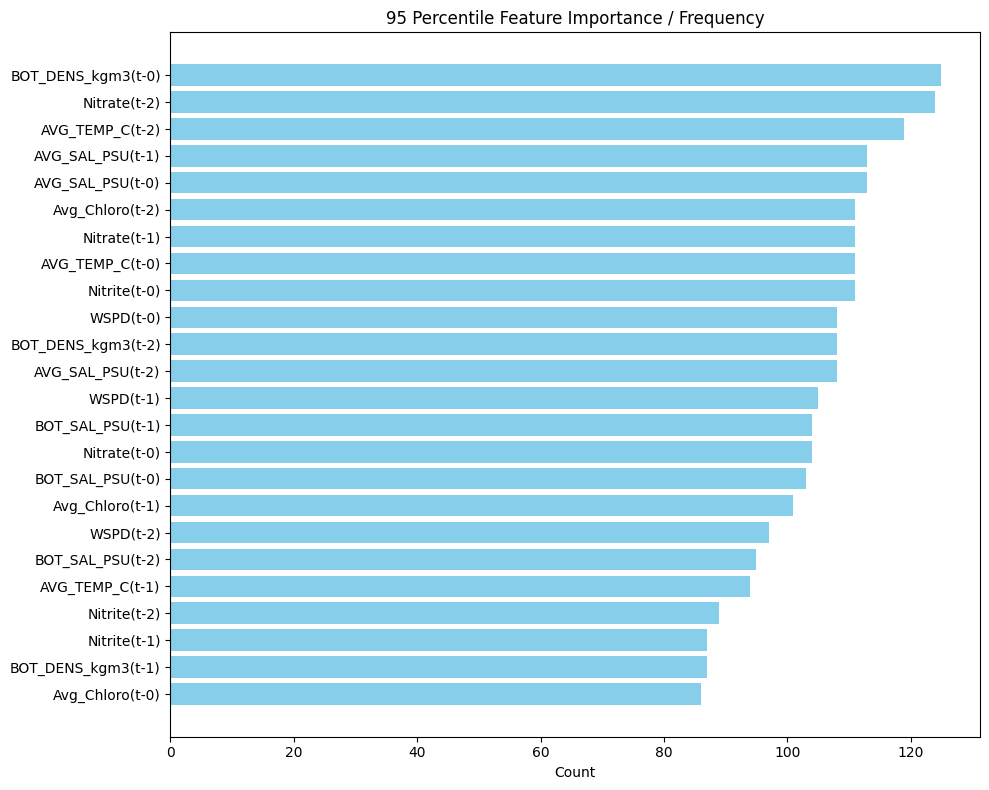

In [9]:
#Find most common parameters

def visualize_common_lags(parameters, percentile):
    #If we want to sort parameters by something else do it HERE
    param_cnts = {}
    print(f'In the {percentile} percentile there are {int(parameters.shape[0] * (1-(percentile/100)))} models')
    for i in range(int(parameters.shape[0] * (1-(percentile/100)))):
        for col in parameters['columns'].iloc[i]:
            if col == f'{target} (t-0)':
                continue  # Skip the target lag
            if col in param_cnts:
                param_cnts[col] += 1
            else:
                param_cnts[col] = 0

    sorted_items = sorted(param_cnts.items(), key=lambda x: x[1], reverse=True)
    features, counts = zip(*sorted_items)

    plt.figure(figsize=(10, 8))
    plt.barh(features, counts, color='skyblue')
    plt.xlabel("Count")
    plt.title(f"{percentile} Percentile Feature Importance / Frequency")
    plt.gca().invert_yaxis()  # Highest count at top
    plt.tight_layout()
    plt.show()



visualize_common_lags(parameters, 95)

In [6]:
#Make prediction based on if p% of n models predict bloom
def eval_ensemble(obs_blooms, pred_blooms):
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]
    

'''
Inputs:
p -> val less than 1 which represents proportions of models which must predict bloom (aka the sensitivity)
n -> from n top models
samp -> num from n*samp top models
outputs -> array of trues and falses of blooms
'''
def ensemble_binary_bloom(parameters_df,n=100,p=0.1,samp=1,bloom_thresh=np.percentile(data[target],95)):
    parameters_df = parameters_df.sort_values(by='rho',ascending=False)
    parameters_df = parameters_df.iloc[:n*samp].sample(n)
    sum = np.zeros(np.array(parameters_df['pred'].iloc[0][1:]).size)
    for i in range(n):
        curr = np.array(parameters_df['pred'].iloc[i][1:]) > bloom_thresh#np.percentile(parameters_df['pred'].iloc[i].iloc[1:],95)#
        sum = sum + curr
    return sum > (n*p)



Bloom threshold is 6.226999999999999


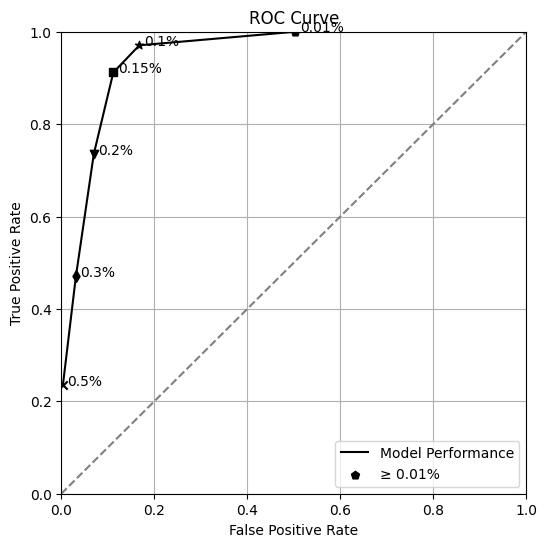

In [7]:
#plot ROC for various sensitivities
bloom_thresh = np.percentile(data[target].iloc[:532],95)
print(f'Bloom threshold is {bloom_thresh}')
results = ensemble_binary_bloom(parameters,samp=1,p=0.1,bloom_thresh=bloom_thresh)
observations = data[target].iloc[-1*len(results):] > bloom_thresh
p_list = [0.01,0.1,0.15,0.2,0.3,0.5]
samp = 2
num_models = 300
TP_list = []
FP_list = []
for p in p_list:
    results = ensemble_binary_bloom(parameters,samp=samp,p=p,bloom_thresh=bloom_thresh,n=num_models)
    eval = eval_ensemble(observations, results)
    TP_list.append(eval[1])
    FP_list.append(eval[2])

markers = ['p', '*', 's', 'v', 'd', 'x']  
plt.figure(figsize=(6,6))
plt.plot(FP_list, TP_list, linestyle='-', color='black', marker='None', label="Model Performance")

for i, (fp, tp, p, marker) in enumerate(zip(FP_list, TP_list, p_list, markers)):
    plt.scatter(fp, tp, marker=marker, color='black', label=f"≥ {p}%" if i == 0 else "")
    plt.text(fp + 0.01, tp, f"{p}%", fontsize=10)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.title("ROC Curve")
plt.show()